In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
# from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile
from qiskit.transpiler.passes import RemoveBarriers

In [3]:
# Import state tomography modules
from qiskit_experiments.library import StateTomography
from osp_solutions.patch_ignis import rename_qcs_StateTomography_to_ignis
from osp_solutions.tomography import StateTomographyFitter
from qiskit.quantum_info import state_fidelity

In [4]:
from osp_solutions.circuits import append_block_trotter_proposed, append_initial_state, append_block_trotter_aj, append_block_trotter_negishi
from osp_solutions.simulator_dm import make_dm_binary, hamiltonian_to_dm, DMExtended
from osp_solutions.hamiltonian import Hamiltonian, make_H_Heisenberg
from osp_solutions.backend_simulator import result_to_dms
from setting import *

In [6]:
###? num_qubits = 5

# The final time of the state evolution
###? time_evolution = np.pi

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')

# initial layout
# initial_layout = [5,3,1]
###? initial_layout = list(range(num_qubits))

# Number of trotter steps
# num_steps_list = [4,10,50,100,200] # ,20,30,40,50] # ,60,70,80,90,100]
###? num_steps_list = list(range(4,100,4))
print("trotter step list: ", num_steps_list)

###? lmd = 1.0

###? state_initial_str = "10101" ### specify initial state
state_initial_dm = DMExtended(matrix=make_dm_binary(str_binary=state_initial_str, 
                                                    endian_binary="little_endian", 
                                                    endian_dm="big_endian")) ### make the density matrix for the initial state

H_Heisenberg = make_H_Heisenberg(num_qubits=num_qubits) ### create Heisenberg Hamiltonian in a dictionary format
matrix_Heisenberg = hamiltonian_to_dm(hamiltonian=H_Heisenberg) ### convert Heisenberg Hamiltonian to its matrix form

U_Heisenberg = DMExtended(sp.linalg.expm(-1.0j * matrix_Heisenberg * time_evolution)) ### prepare the unitary matrix of the Heisenberg Hamiltonian

state_target_dm = state_initial_dm.apply_unitary(U_Heisenberg) ### apply the unitary evolution to the density matrix
state_target_dm.is_valid()

trotter step list:  [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96]


True

In [7]:
fidelities = []
nums_cnots = []

for num_steps in num_steps_list:
    
    print("trotter steps: ", num_steps)
    t1 = time.perf_counter()
    
    # Initialize quantum circuit for 3 qubits
    qc = QuantumCircuit(num_qubits)

    # Prepare initial state
    append_initial_state(qc=qc, 
                         state_initial_str=state_initial_str)
    append_block_trotter_proposed(qc=qc, 
                                  dt=dt,  ###!
                                  lmd= lmd, ### !
                                  num_steps=num_steps, ###!
                                 )

    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.assign_parameters({dt: time_evolution / num_steps})
    qc_t3 = transpile(RemoveBarriers()(qc), optimization_level=3, basis_gates=["sx", "cx", "rz"])
    qc_t3.save_density_matrix()
    
    ### execute circuits
    result_raw = simulator_ideal.run(qc_t3,
                                        shots=0,
                                        ).result()
    dm_raw = result_to_dms(result=result_raw,
                        endian_dm="big")[0]

    fidelities.append(state_fidelity(dm_raw, state_target_dm))
    nums_cnots.append(qc_t3.count_ops().get("cx"))
    
    t2 = time.perf_counter()
    print('raw state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fidelities), np.std(fidelities)))
    print("number of CNOT gates:", qc_t3.count_ops().get("cx"))
    print("time:", t2 - t1)
    print()

trotter steps:  4
raw state tomography fidelity = 0.2417 ± 0.0000
number of CNOT gates: None
time: 0.021697083953768015

trotter steps:  8
raw state tomography fidelity = 0.1250 ± 0.1167
number of CNOT gates: 56
time: 0.012632624944671988

trotter steps:  12
raw state tomography fidelity = 0.1812 ± 0.1241
number of CNOT gates: 84
time: 0.017098500160500407

trotter steps:  16
raw state tomography fidelity = 0.3104 ± 0.2483
number of CNOT gates: 112
time: 0.02019187482073903

trotter steps:  20
raw state tomography fidelity = 0.4169 ± 0.3077
number of CNOT gates: 140
time: 0.024822542211040854

trotter steps:  24
raw state tomography fidelity = 0.4978 ± 0.3341
number of CNOT gates: 168
time: 0.027562875067815185

trotter steps:  28
raw state tomography fidelity = 0.5598 ± 0.3446
number of CNOT gates: 196
time: 0.03281912510283291

trotter steps:  32
raw state tomography fidelity = 0.6084 ± 0.3470
number of CNOT gates: 224
time: 0.0397557090036571

trotter steps:  36
raw state tomography

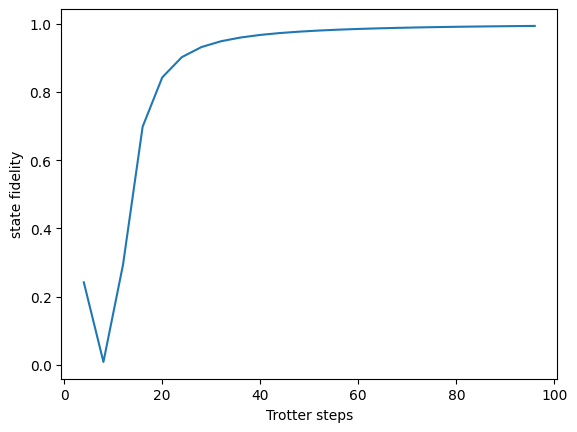

In [8]:
plt.plot(num_steps_list, fidelities)
plt.xlabel("Trotter steps")
plt.ylabel("state fidelity")
plt.show()

In [9]:
with open("run_trotter_"+str(num_qubits)+"-qubit_proposed.pkl", "wb") as f:
    pickle.dump({"num_steps_list": num_steps_list, "fidelities": fidelities, "nums_cnots": nums_cnots}, f)

In [10]:
# qc.draw("mpl")

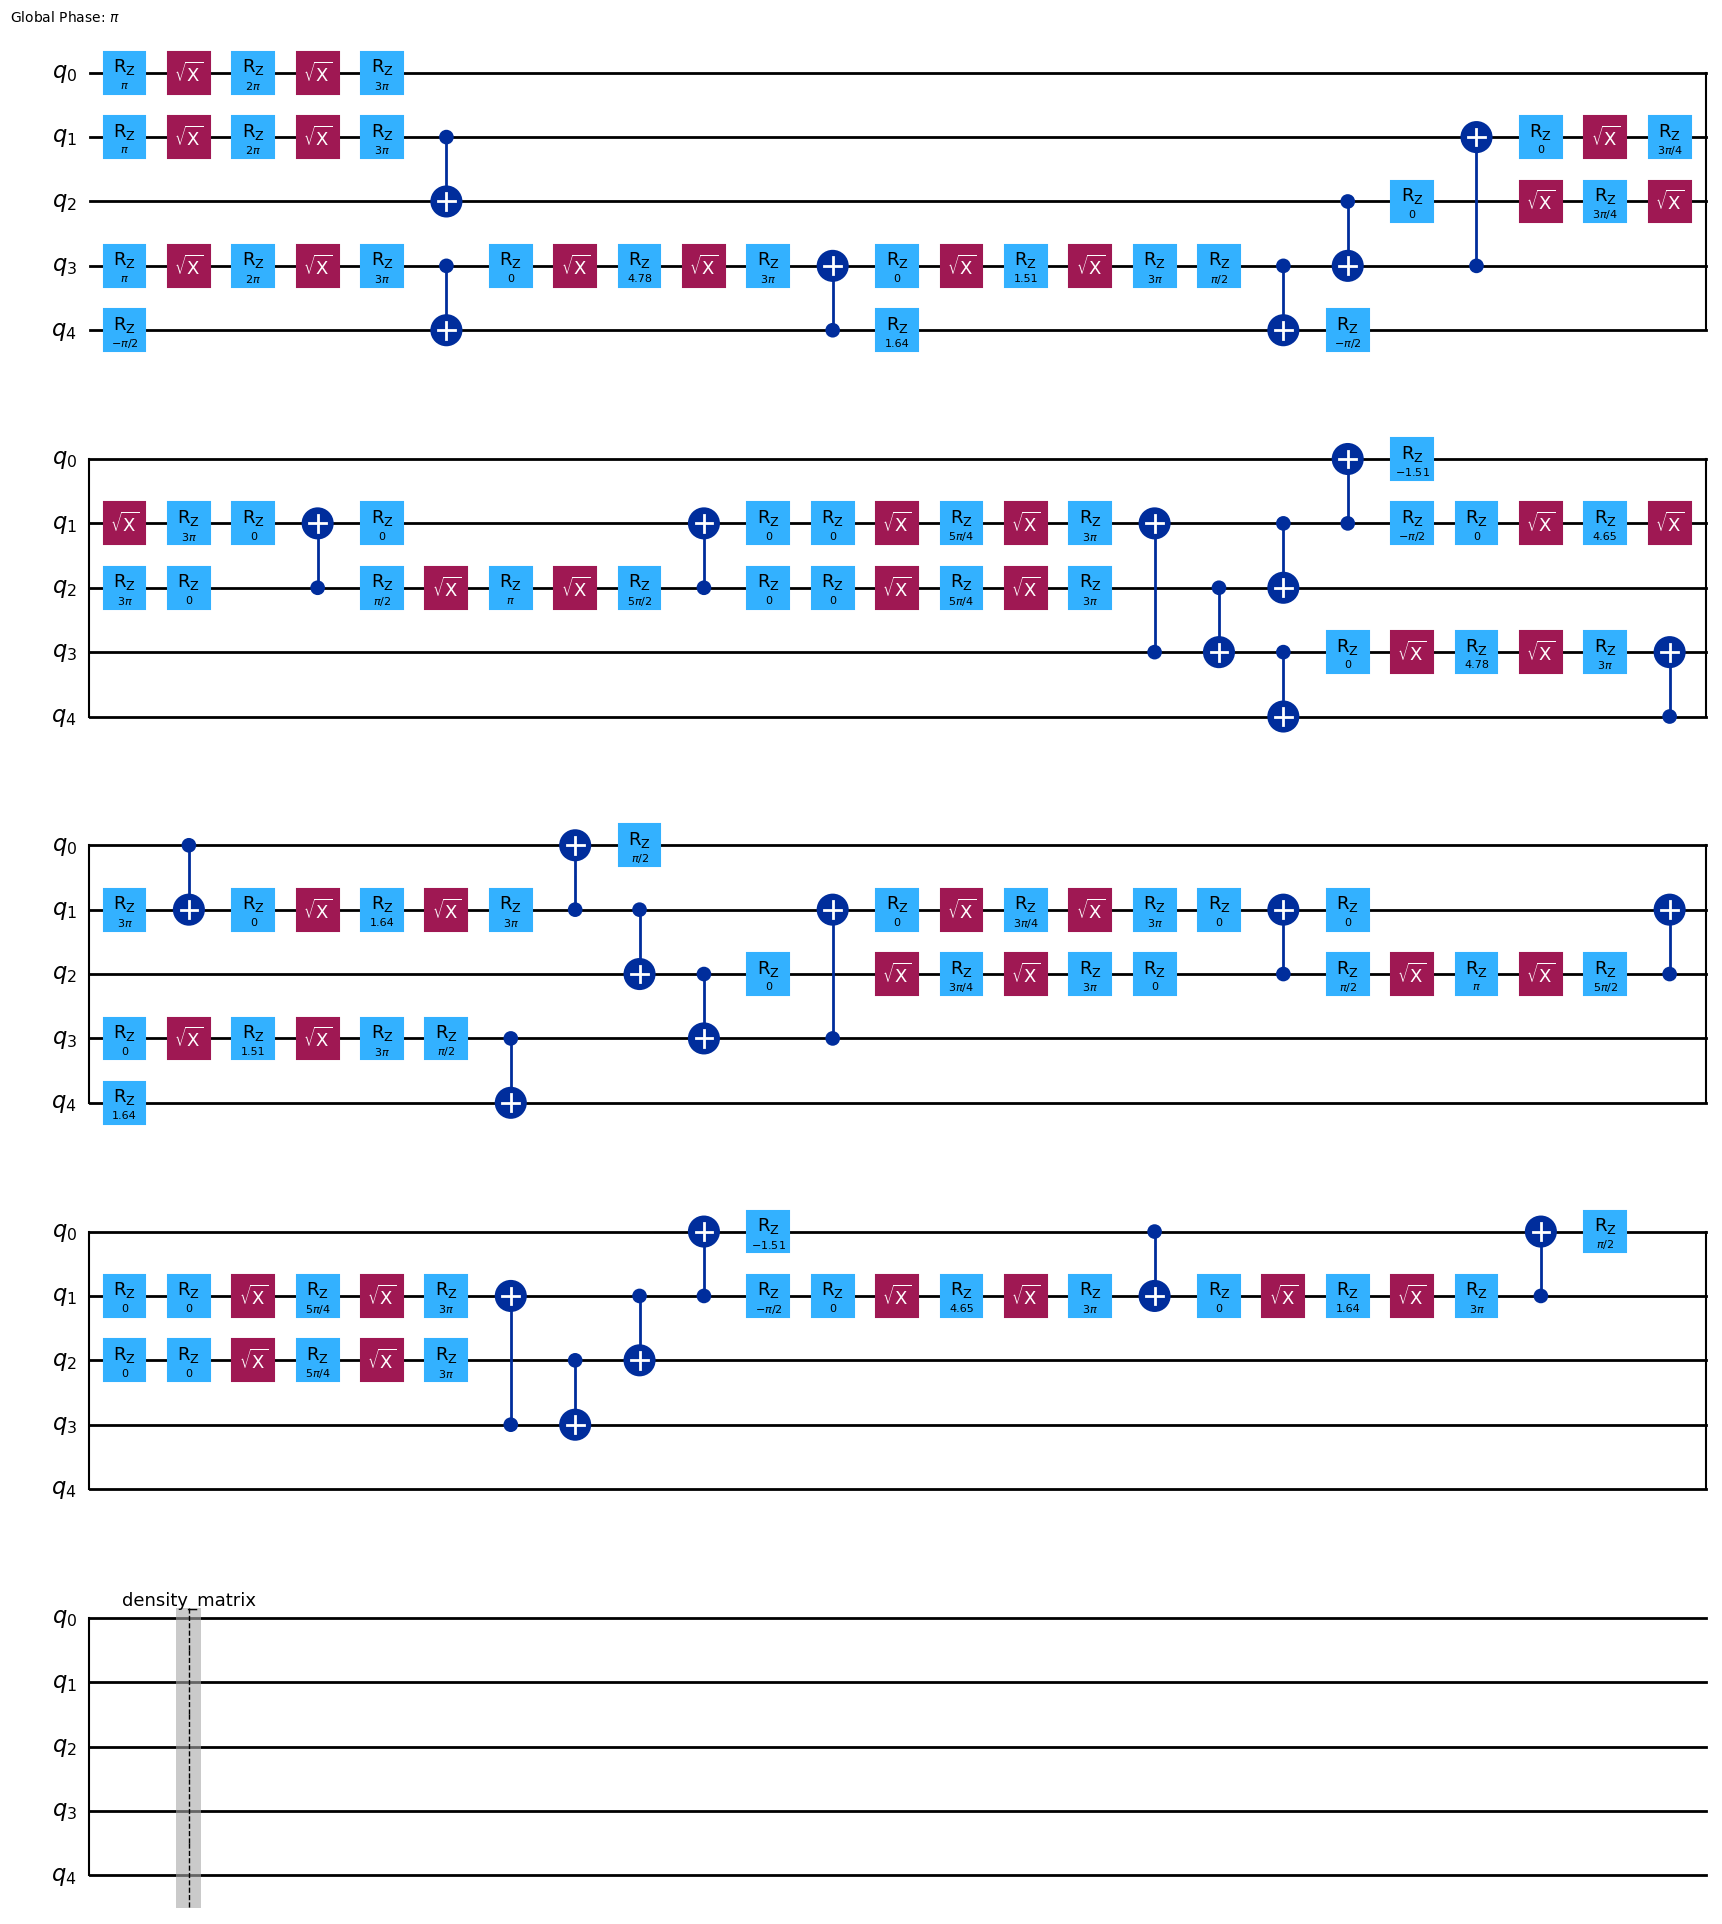

In [11]:
qc = QuantumCircuit(num_qubits)

# Prepare initial state
append_initial_state(qc=qc, 
                        state_initial_str=state_initial_str)
append_block_trotter_proposed(qc=qc, 
                              dt=dt / 2, 
                              lmd= - 1.0, ### !
                              num_steps=2 * 2)

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.assign_parameters({dt: time_evolution / num_steps})
# qc_t3 = transpile(RemoveBarriers()(qc), optimization_level=3, basis_gates=["sx", "cx", "rz"])
qc_t3 = transpile(qc, optimization_level=0, basis_gates=["sx", "cx", "rz"])
qc_t3.save_density_matrix()
qc_t3.draw("mpl")

In [12]:
print(simulator_noisy)

AerSimulator('aer_simulator_density_matrix'
             noise_model=<NoiseModel on ['s', 'sx', 'rx', 'cx', 'u2', 'x', 'rz', 'h', 'u1', 'cz', 'u3', 'sdg']>)
